<a href="https://colab.research.google.com/github/aoluwatooni/sentence-generator-for-indigenous-nigerian-language/blob/add-up/001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import neccessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import nltk
import numpy as np
import pandas as pd
import re
import pickle

In [ ]:
# Testing if GPU is active
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Import Data from url
!wget https://raw.githubusercontent.com/Niger-Volta-LTI/yoruba-text/master/Owe/owe.txt

--2022-09-22 20:59:22--  https://raw.githubusercontent.com/Niger-Volta-LTI/yoruba-text/master/Owe/owe.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180836 (177K) [text/plain]
Saving to: ‘owe.txt.1’

owe.txt.1           100%[===================>] 176.60K  --.-KB/s    in 0.003s  

2022-09-22 20:59:23 (61.3 MB/s) - ‘owe.txt.1’ saved [180836/180836]



In [ ]:
# Load data
with open("owe.txt", "r") as file:
  data = file.readlines()
  # using regular expression to remove punctuations from each line
  data = re.sub(r"[^\w\s]","",''.join(data)).lower().split('\n')
  #data = ' '.join(data).lower().split('\n')

del data[0] # whitespace
del data[-1] # whitespace
print(len(data))
# deleting lines containing english words
print(data[50])
del data[50]
print(data[823])
del data[823]
print(data[2075:2077])
del data[2075:2077]
print(data[2076:2079])
del data[2076:2079]
print()
print(len(data))

2700
what is the clothselling woman have to sell that she carries a whip in her hand
the following is a variant
['compare mo mọọ gùn   ', 'compare mo gbọn tán    ']
['compare the preceding entry', 'compare mo gbọn tán    ', 'compare mo gbọn tan    ']

2693


In [ ]:
df = pd.DataFrame(data, columns=['owe'])
df.head()

,owe
0,a di gàárì sílẹ ewúrẹ ńyọjú ẹrù ìran rẹ ni
1,a kì í dàgbà má làáyà ibi ayé bá báni là ńjẹ ẹ
2,àgbà kán ṣe bẹẹ lógùn yemaja ló gbé e lọ
3,ibi tí oyín gbé ńhó tí àdó ńhó ìfun ò dákẹ lásán
4,ìdí òwò ni òwòó gbé tà


## Data Preprocessing(Removing Stopwords, Tokenization, Sequencing and Sequence Padding)

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
# Function for text cleaning
def stopwords_(text):
    # Remove english stop words
    stop_words = set(stopwords.words('english')) - set(['a','i','o','re','to','an','so','ma'])
    stop_words.update(['compare'])
    cleaned_text = ' '.join([w for w in text.split() if w in stop_words])
    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['stopwords'] = df['owe'].apply(stopwords_)

In [ ]:
df.sample(5)

,owe,stopwords
2465,asọẹhìnkùlé ba araa rẹ nínú jẹ ohun tó wuni là...,
1910,a kì í kórira ọfọnọn ká finá bọ ahéré,
2339,adánilóró fagbára kọni,
1042,àgbàká lẹsẹ ńgba ọna,
348,ajá ilé ò mọdẹẹ ṣe,


In [ ]:
df['stopwords'].unique()

array(['', 'compare', 'too', 'he', 'in'], dtype=object)

In [ ]:
df[df['stopwords']=='compare']

,owe,stopwords
256,compare bí a bá dàgbà à yé ogunún jà,compare
1544,compare wọn ní àwòko o bú ọba,compare


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
# Function for text cleaning
def clean_text(text):
    # Remove english stop words
    stop_words = set(stopwords.words('english')) - set(['a','i','o','re','to','an','so','ma'])
    stop_words.update(['compare'])
    cleaned_text = ' '.join([w for w in text.split() if not w in stop_words])
    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['clean_owe'] = df['owe'].apply(clean_text)

In [ ]:
df.sample(5)

,owe,stopwords,clean_owe
1038,àgbà tí kò tó ọmọdéé rán níṣẹ ní ńsọ pé kó bu ...,,àgbà tí kò tó ọmọdéé rán níṣẹ ní ńsọ pé kó bu ...
1908,èrò ọnà ni yó ròhìn ọkà tó gbó,,èrò ọnà ni yó ròhìn ọkà tó gbó
578,àjàpá ńlọ sájò wọn ní ìgbà wo ni yó dèé ó ní ó...,,àjàpá ńlọ sájò wọn ní ìgbà wo ni yó dèé ó ní ó...
1719,obìnrin abàlèmẹfà àlè mẹfà ò mọ ara wọn,,obìnrin abàlèmẹfà àlè mẹfà ò mọ ara wọn
1545,a kì í pè é lẹrù ká pè é lọṣọọ,,a kì í pè é lẹrù ká pè é lọṣọọ


In [ ]:
# convert column to a list of each row
data = [line for line in df['clean_owe']]

In [ ]:
# Instantiating tokenizer
tokenizer = Tokenizer()

# Assigning a new variable name to data
corpus = data

# Create tokens of each words as a dictionary with key being word and the value beings its token
tokenizer.fit_on_texts(corpus)

#calculating total number of words in the data
total_words = len(tokenizer.word_index) + 1

print(total_words)
print(tokenizer.word_index)


5096
{'a': 1, 'ní': 2, 'ò': 3, 'í': 4, 'kì': 5, 'ó': 6, 'bí': 7, 'bá': 8, 'tí': 9, 'tó': 10, 'ẹni': 11, 'fi': 12, 'kò': 13, 'ni': 14, 'jẹ': 15, 'ṣe': 16, 'ká': 17, 'ẹ': 18, 'mọ': 19, 'kí': 20, 'là': 21, 'o': 22, 'ti': 23, 'kó': 24, 'rẹ': 25, 'yó': 26, 'òun': 27, 'lọ': 28, 'sí': 29, 'rí': 30, 'ló': 31, 'á': 32, 'ọmọ': 33, 'ojú': 34, 'pa': 35, 'wọn': 36, 'lè': 37, 'ohun': 38, 'gbé': 39, 'à': 40, 'má': 41, 'fún': 42, 'pé': 43, 'la': 44, 'ọ': 45, 'máa': 46, 'ta': 47, 'wá': 48, 'tán': 49, 'kan': 50, 'sọ': 51, 'kú': 52, 'mú': 53, 'ilé': 54, 'ara': 55, 'ẹní': 56, 'àgbà': 57, 'ńjẹ': 58, 'ọjọ': 59, 'ajá': 60, 'di': 61, 'ibi': 62, 'kọ': 63, 'baba': 64, 'bọ': 65, 'ọlẹ': 66, 'èèyàn': 67, 'fẹ': 68, 'orí': 69, 'adìẹ': 70, 'gbọ': 71, 'mi': 72, 'ńṣe': 73, 'lójú': 74, 'ọwọ': 75, 'ńpa': 76, 'ọràn': 77, 'lọwọ': 78, 'ọmọdé': 79, 'òún': 80, 'ṣéé': 81, 'sílẹ': 82, 'wo': 83, 'gba': 84, 'gbogbo': 85, 'dá': 86, 'ju': 87, 'ọrọ': 88, 'bó': 89, 'mí': 90, 'gbà': 91, 'oko': 92, 'inú': 93, 'ẹnu': 94, 'mo': 95, 'dé':

In [ ]:
# Training features
input_sequences = []

for line in corpus:
  # Converts each sentence as its tokenized equivalent
  token_list = tokenizer.texts_to_sequences([line])[0]
  
  for i in range(1,len(token_list)):
    #generating n_gram sequences: 1st two words in the token_list is one sequence, next two words are another sequence and so on
      n_gram_sequence = token_list[:i+1]
      #appending each n_gram sequence to the list of our features
      input_sequences.append(n_gram_sequence)
print("The training features are:\n",input_sequences)

## 'Pre' padding the sequences with '0' to bring them to equal array length

In [ ]:
# Calculating the length of the longest sequence in our training features
max_sequence_len = max([len(x) for x in input_sequences])

#pre-pading each value of the input_sequence
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,padding='pre'))
print(input_sequences)

[[   0    0    0 ...    0    1   61]
 [   0    0    0 ...    1   61 1281]
 [   0    0    0 ...   61 1281   82]
 ...
 [   0    0    0 ...   31   23  212]
 [   0    0    0 ...   23  212   32]
 [   0    0    0 ...  212   32   49]]


In [ ]:
# Create predictors and label using numpy slicing
features = input_sequences[:,:-1]
labels = input_sequences[:,-1]

# Creating one hot encoding values of each labels 
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Modelling

**PS: One rule of thumb is that the embedding dimension should be approximately 1.6 times the square root of the number of unique elements in the category**

In [ ]:
# Set embedding dimension for embedding layer
output_dim = int(np.sqrt(total_words) * 1.6)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, output_dim=output_dim, input_length=max_sequence_len - 1))
model.add(LSTM(400, dropout=0.2, return_sequences=True))
model.add(LSTM(400))
model.add(Dense(total_words, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 57, 114)           580944    
                                                                 
 lstm_1 (LSTM)               (None, 57, 400)           824000    
                                                                 
 lstm_2 (LSTM)               (None, 400)               1281600   
                                                                 
 dense_1 (Dense)             (None, 5096)              2043496   
                                                                 
Total params: 4,730,040
Trainable params: 4,730,040
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We will also be using **ModelCheckpoint()** to save the best model with lowest  loss.

In [ ]:
# filename = 'model-{epoch:02d}-{loss:.4f}.hdf5'
# checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(features,labels,epochs=500,verbose=1)#,callbacks=[checkpoint])

Epoch 1/500
763/763 [==============================] - 21s 17ms/step - loss: 6.8062 - accuracy: 0.0478
Epoch 2/500
763/763 [==============================] - 13s 17ms/step - loss: 6.3655 - accuracy: 0.0692
Epoch 3/500
763/763 [==============================] - 13s 17ms/step - loss: 6.0839 - accuracy: 0.0918
Epoch 4/500
763/763 [==============================] - 13s 17ms/step - loss: 5.7924 - accuracy: 0.1115
Epoch 5/500
763/763 [==============================] - 13s 18ms/step - loss: 5.5275 - accuracy: 0.1255
Epoch 6/500
763/763 [==============================] - 13s 18ms/step - loss: 5.2736 - accuracy: 0.1391
Epoch 7/500
763/763 [==============================] - 13s 18ms/step - loss: 5.0128 - accuracy: 0.1507
Epoch 8/500
763/763 [==============================] - 13s 18ms/step - loss: 4.7486 - accuracy: 0.1579
Epoch 9/500
763/763 [==============================] - 13s 18ms/step - loss: 4.4820 - accuracy: 0.1730
Epoch 10/500
763/763 [==============================] - 13s 17ms/step - l

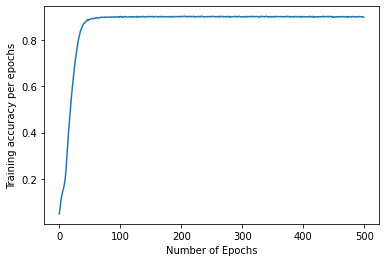

In [ ]:
#plotting the training accuracy of the model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel("Number of Epochs")
plt.ylabel('Training accuracy per epochs')
plt.show()

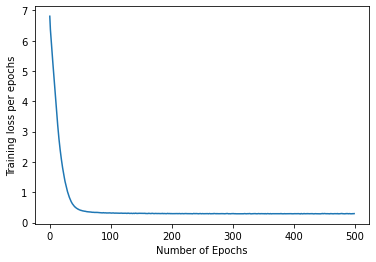

In [ ]:
#plotting the training loss of the model
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel("Number of Epochs")
plt.ylabel('Training loss per epochs')
plt.show()

In [ ]:
history.history['loss']

[6.806185245513916,
 6.3655314445495605,
 6.0839457511901855,
 5.792417526245117,
 5.527519702911377,
 5.27364444732666,
 5.012753009796143,
 4.748636722564697,
 4.482024669647217,
 4.216409206390381,
 3.955956220626831,
 3.6944353580474854,
 3.4454338550567627,
 3.206897020339966,
 2.980922222137451,
 2.767301559448242,
 2.5761520862579346,
 2.399405002593994,
 2.2343766689300537,
 2.0849521160125732,
 1.940827488899231,
 1.8078968524932861,
 1.6867765188217163,
 1.5720349550247192,
 1.4630954265594482,
 1.3562755584716797,
 1.2704448699951172,
 1.181187391281128,
 1.100226640701294,
 1.023825764656067,
 0.9600651860237122,
 0.8916704654693604,
 0.8371403813362122,
 0.7871437072753906,
 0.7349424362182617,
 0.6939928531646729,
 0.6578885316848755,
 0.6217867136001587,
 0.5948863625526428,
 0.5663439035415649,
 0.5422190427780151,
 0.5176188349723816,
 0.5089214444160461,
 0.48646774888038635,
 0.4712114930152893,
 0.46072688698768616,
 0.4448617696762085,
 0.440601646900177,
 0.425010

## Text Prediction. A seed text to start the predicted proverbs is preprocessed exactly as the training data is 

In [ ]:
def generate_proverbs(seed_text,next_words):
    """ A function that takes a 
    seed_text: to prompt next word prediction
    next_word: The number of next words to predict
    and returns the predicted yoruba proverbs"""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        classes=np.argmax(predicted,axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

## Generate yoruba proverbs

In [ ]:
generate_proverbs('afẹfẹ',15)

'afẹfẹ tó wọlé tó kó aṣọ iyàrá ìkìlọ ni fún ẹni tó wọ tiẹ sọrùn tó'

In [ ]:
generate_proverbs('àtẹnumọ',15)

'àtẹnumọ kì í ru ẹṣin ṣọtá dé ẹṣin sí ìlú tí a ó rílẹ fi wọ'

In [ ]:
alist = ['ńwúṣu','àgbà','ewúrẹ']
for word in alist:
  print(generate_proverbs(word,15))

ńwúṣu ní ḿbẹ nínú isà tí yó ba òkú lẹrù ká ṣeé lọ lọ lọ lọ
àgbà tí kò lẹsẹ nílẹ a lọgbọn nínú tí ilẹẹ fi ńyọ ṣeré tán là ńra
ewúrẹ ò wí pé òun ò ṣọmọ àgùntàn àgùntàn ló wí pé òun ò ṣọmọ ewúrẹ


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# save model 
model.save("/content/gdrive/My Drive/model500ep.h5")

In [ ]:
# Reset model 
from keras import backend as K
del model
K.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
# translator library
!pip install deep-translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 13.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from deep_translator import GoogleTranslator

In [ ]:
to_translate = generate_proverbs('obìnrin',15)
translated = GoogleTranslator(source='auto', target='en').translate(to_translate)
print(to_translate)
translated

obìnrin tó gégi nígbó orò ó gé àgémọ mẹta gbó mélòó ni ọlọmọọ máa lò gbó


'A woman who cuts a forest will cut three pieces of wood'

In [ ]:
to_translate = generate_proverbs('ọkùnrin',15)
translated = GoogleTranslator(source='auto', target='en').translate(to_translate)
print(to_translate)
translated


ọkùnrin jẹjẹ abìwàkunkun ara ẹ ó ní òún ḿba àkọ jẹ ọ a ṣara bòró o


'A man is a bad person, he will eat you and you will be hurt'

In [ ]:
to_translate = generate_proverbs('abìwàkunkun',15)
translated = GoogleTranslator(source='auto', target='en').translate(to_translate)
print(to_translate)
translated

abìwàkunkun ní ọjọ gbogbo lòún mọ òun ò mọ ọjọ mìíràn lọsànán igba wọn máa kú


'he behaves in the dark every day he knows that he does not know another day in the day when they will die'